## Import the required packages

In [39]:
import pandas as pd
import yfinance as yf
import datetime

import pmdarima as pm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Select asset and time period

In [40]:
start_training = datetime.date(2021, 10, 14)
end_training = datetime.date(2022, 8, 1)
start_testing = datetime.date(2021, 8, 2)
end_testing = datetime.datetime.today()
ticker = "NVDA"

## Download training data

In [41]:
df_training = yf.download(ticker, start=start_training, end=end_training, progress=False)
print(f"Downloaded {df_training.shape[0]} rows and {df_training.shape[1]} columns of {ticker} data")

Downloaded 199 rows and 6 columns of NVDA data


## Convert daily dataset to weekly dataset

In [42]:
# Only use the 'Close' column
df_training.drop(columns=["Open", "High", "Low", "Adj Close"], inplace=True)
print(df_training.tail())

                                Close    Volume
Date                                           
2022-07-25 00:00:00-04:00  170.240005  48074800
2022-07-26 00:00:00-04:00  165.330002  39786500
2022-07-27 00:00:00-04:00  177.899994  56977600
2022-07-28 00:00:00-04:00  179.839996  47464600
2022-07-29 00:00:00-04:00  181.630005  43546000


In [43]:
start_training_str = (start_training + pd.Timedelta("5 days")).strftime("%B %Y")
end_training_str = (end_training - pd.Timedelta("5 days")).strftime("%B %Y")

<AxesSubplot:title={'center':'NVDA close prices (October 2021 - July 2022)'}, xlabel='Date'>

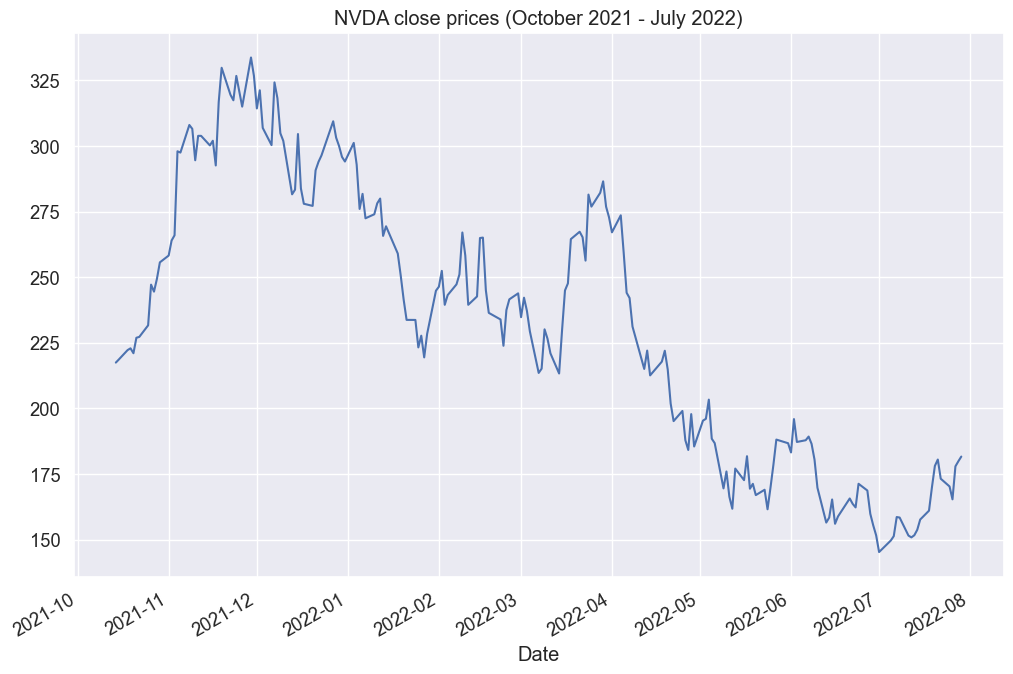

In [44]:
sns.set(font_scale=1.2)
df_training['Close'].plot(figsize=(12, 8), 
                     title=f"{ticker} close prices ({start_training_str} - {end_training_str})")

## Model Selection

In [45]:
## Fitting the model(With more tuning of the parameters)
arima_fit = pm.auto_arima(df_training['Close'], error_action='ignore', suppress_warnings=True, stepwise=False, 
                           approximation=False, seasonal=True)

## Printing a summary of the model
arima_fit.summary()

/Users/apple/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.po

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  199
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -725.912
Date:                Sun, 23 Oct 2022   AIC                           1455.825
Time:                        14:45:42   BIC                           1462.401
Sample:                             0   HQIC                          1458.487
                                - 199                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1810      0.699     -0.259      0.796      -1.551       1.189
sigma2        89.5297      8.802     10.172      0.000      72.278     106.781
===================================================================================
Ljung-Box (L1) (Q):                   0.65   Jarque-Bera (JB):                 6.11
Prob(Q):                              0.42   Prob(JB):                         0.05
Heteroskedasticity (H):               0.50   Skew:                             0.41
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Testing data

In [46]:
df_testing = yf.download(ticker, start=start_testing, end=end_testing, progress=False)
print(f"Downloaded {df_testing.shape[0]} rows and {df_testing.shape[1]} columns of {ticker} data")

Downloaded 310 rows and 6 columns of NVDA data


In [47]:
df_testing.drop(columns=["Open", "High", "Low", "Adj Close"], inplace=True)
print(df_testing.head())

                                Close    Volume
Date                                           
2021-08-02 00:00:00-04:00  197.500000  21744400
2021-08-03 00:00:00-04:00  198.149994  30181100
2021-08-04 00:00:00-04:00  202.740005  23130900
2021-08-05 00:00:00-04:00  206.369995  21143500
2021-08-06 00:00:00-04:00  203.660004  17849700


## Forecast using testing data

In [48]:
n_fcast1 = len(df_testing)

In [49]:
arima_fcast = arima_fit.predict(n_periods=n_fcast1,
return_conf_int = True, alpha = 0.05)

/Users/apple/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [50]:
arima_fcast = pd.DataFrame(arima_fcast[0], columns=['prediction'])

In [51]:
arima_fcast

,prediction
199,181.449045
200,181.268086
201,181.087126
202,180.906166
203,180.725207
...,...
504,126.256366
505,126.075406
506,125.894446
507,125.713487


In [52]:
arima_fcast.reset_index(inplace = True)
arima_fcast = arima_fcast.drop('index', axis = 1)

In [53]:
df_testing = pd.DataFrame(df_testing['Close'])
df_testing.reset_index(inplace = True)
#pd.concat([arima_fcast, df_testing], ignore_index=True)
df_testing

,Date,Close
0,2021-08-02 00:00:00-04:00,197.500000
1,2021-08-03 00:00:00-04:00,198.149994
2,2021-08-04 00:00:00-04:00,202.740005
3,2021-08-05 00:00:00-04:00,206.369995
4,2021-08-06 00:00:00-04:00,203.660004
...,...,...
305,2022-10-17 00:00:00-04:00,118.879997
306,2022-10-18 00:00:00-04:00,119.669998
307,2022-10-19 00:00:00-04:00,120.510002
308,2022-10-20 00:00:00-04:00,121.940002


In [54]:
#pd.concat([arima_fcast, df_testing])

In [55]:
arima_fcast

,prediction
0,181.449045
1,181.268086
2,181.087126
3,180.906166
4,180.725207
...,...
305,126.256366
306,126.075406
307,125.894446
308,125.713487


In [56]:
df_testing = pd.DataFrame(df_testing['Close'])

In [57]:
arima_fcast = arima_fcast.join(df_testing)

## Plot the results

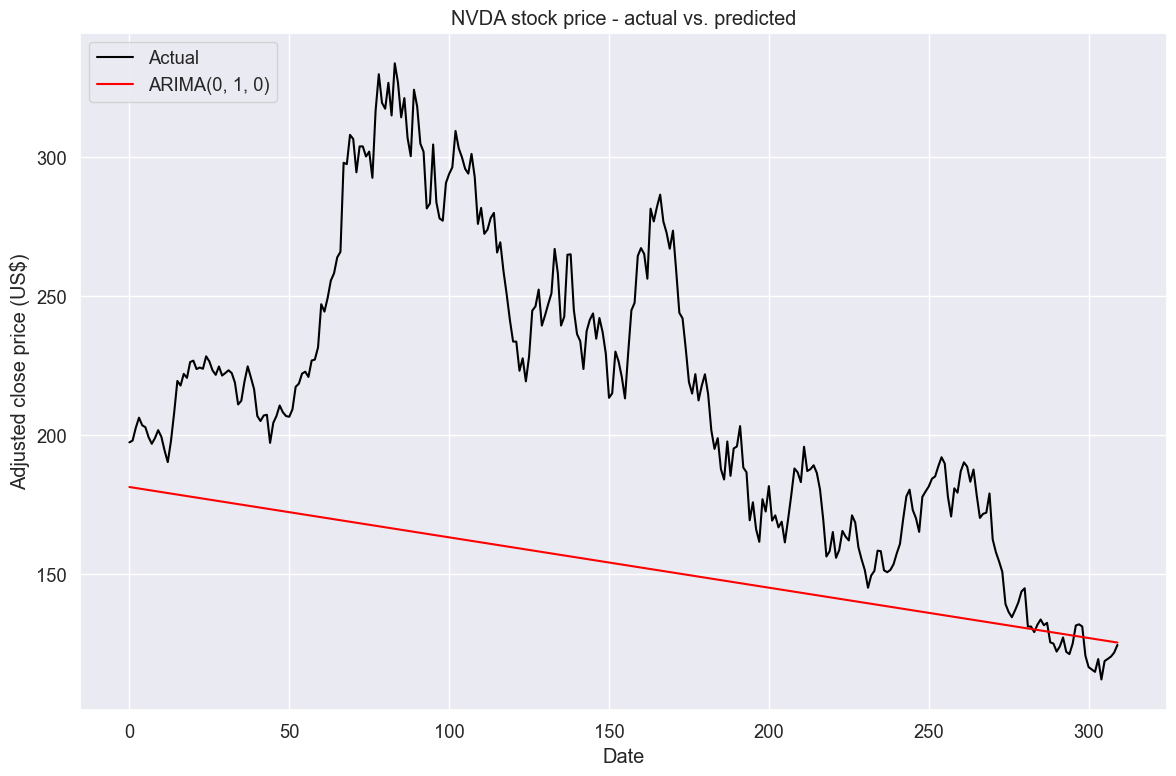

In [58]:
fig, ax = plt.subplots(1, figsize=(12, 8))

ax = sns.lineplot(data=df_testing['Close'], color='black', label='Actual')

ax.plot(arima_fcast.prediction, color='red', label='ARIMA(0, 1, 0)')

ax.set(title=f"{ticker} stock price - actual vs. predicted", xlabel='Date',
       ylabel='Adjusted close price (US$)')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Fit the model on all data

In [59]:
start_fit = datetime.date(2022, 8, 2)
end_fit = datetime.datetime.today()

In [60]:
full_data = yf.download(ticker, start=start_fit, end=end_fit, progress=False)

In [61]:
model2 = pm.auto_arima(full_data['Close'], error_action='ignore', suppress_warnings=True, stepwise=False, 
                           approximation=False, seasonal=True)

/Users/apple/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.po

In [88]:
prediction = model2.predict(n_periods=10,
return_conf_int = True, alpha = 0.05)

/Users/apple/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [89]:
prediction = pd.DataFrame(prediction[0])
prediction.reset_index(inplace = True)
prediction.drop('index', axis = 1, inplace = True)
prediction.reset_index(inplace = True)

In [90]:
prediction = prediction.rename(columns={0: 'Close'})

In [91]:
prediction

,index,Close
0,0,123.596846
1,1,122.533688
2,2,121.470530
3,3,120.407373
4,4,119.344215
5,5,118.281057
6,6,117.217900
7,7,116.154742
8,8,115.091584
9,9,114.028426


In [92]:
prediction.to_csv('model2.csv',index=False)